# Macro-expressions Predictor

In order to try the system, execute the following boxes, changing the variable name to access to your own images or files. New indications will be given.

In [1]:
import keras
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.image as mpimg
from keras.models import Sequential
from keras.layers import Conv2D,AveragePooling2D,Dropout
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.preprocessing import image
from keras.models import load_model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
from keras.preprocessing import image as kimg
from matplotlib.pyplot import *
from imutils.face_utils.helpers import FACIAL_LANDMARKS_IDXS
from imutils.face_utils.helpers import shape_to_np
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import imutils
import dlib

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Alert that shows if the CPU or GPU are working
config = tf.ConfigProto( device_count = {'GPU': 0 , 'CPU': 56} ) #max: 1 gpu, 56 cpu
sess = tf.Session(config=config) 
keras.backend.set_session(sess)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 584925244972483737
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3317235712
locality {
  bus_id: 1
}
incarnation: 12138881626066625356
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


# Model Acquisition

The model has already been trained with the other jupyter file (Macro-expressions_training&evaluation), to use it it needs to be loaded.

In [184]:
model = load_model('models/4.5.2_Aligned+Cropped.h5')

# Image Preprocessing - Alignment, Cropping & Light Intensity Normalization

These functions will plot the final predictions and prepare the images (aligning and cropping the facial region ) to send them to the CNN model.

In [4]:
def plot_emotion(predicted_label):
    """
        Given an array containing 7 probabilities, it plots a chart indicating the amount of each probability, 
        which will indicate the emotions predicted.

        :param: predicted_label, array of predictions.

    """
        
    objects = ('Anger', 'Disgust', 'Sadness', 'Happiness', 'Fear', 'Surprise', 'Neutral')
    y_pos = np.arange(len(objects))
    
    plt.bar(y_pos, predicted_label, align='center', alpha=0.5, width=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('Percentage')
    plt.xlabel('Macro-expression')
    plt.title('Emotion recognition')
    plt.gray()
    
plt.show()

In [159]:
def zoom_alignment(gray, face): 

    """
       Alignment of a picture respect to the face and cropping it afterwards.

        :param: gray, image already converted to grayscale.
        :param: rect, facial region.
        :return: Picture with the face aligned and cropped.

   """

    desiredLeftEye=(0.24, 0.26)
    desiredFaceWidth = 48
    desiredFaceHeight = 48
    predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

    # Use an existent predictor
    shape = predictor(gray, rect)
    shape = shape_to_np(shape)

    # Obtain the left and right eyes (x,y) coordinates
    (lStart, lEnd) = FACIAL_LANDMARKS_IDXS["left_eye"]
    (rStart, rEnd) = FACIAL_LANDMARKS_IDXS["right_eye"]
    leftEyePts = shape[lStart:lEnd]
    rightEyePts = shape[rStart:rEnd]

    # Compute the center of mass for each eye
    leftEyeCenter = leftEyePts.mean(axis=0).astype("int")
    rightEyeCenter = rightEyePts.mean(axis=0).astype("int")

    # Compute the angle between the eye centroids
    dY = rightEyeCenter[1] - leftEyeCenter[1]
    dX = rightEyeCenter[0] - leftEyeCenter[0]
    angle = np.degrees(np.arctan2(dY, dX)) - 180

    # Compute the desired right eye x-coordinate based on the desired x-coordinate of the left eye
    desiredRightEyeX = 1.0 - desiredLeftEye[0]

    # Determine the scale of the new resulting image by taking the ratio of the distance between eyes
    # in the *current* image to the ratio of distance between eyes in the *desired* image
    dist = np.sqrt((dX ** 2) + (dY ** 2))
    desiredDist = (desiredRightEyeX - desiredLeftEye[0])
    desiredDist *= desiredFaceWidth
    scale = desiredDist / dist

    # Compute center (x, y)-coordinates between the two eyes in the input image
    eyesCenter = ((leftEyeCenter[0] + rightEyeCenter[0]) // 2,
    (leftEyeCenter[1] + rightEyeCenter[1]) // 2)

    # Grab the rotation matrix for rotating and scaling the face
    M = cv2.getRotationMatrix2D(eyesCenter, angle, scale)

    # Update the translation component of the matrix
    tX = desiredFaceWidth * 0.5
    tY = desiredFaceHeight * desiredLeftEye[1]
    M[0, 2] += (tX - eyesCenter[0])
    M[1, 2] += (tY - eyesCenter[1])

    # Apply the affine transformation
    (w, h) = (desiredFaceWidth, desiredFaceHeight)
    output = cv2.warpAffine(gray, M, (w, h), flags=cv2.INTER_CUBIC) 
    
    return output

## Static images

In order to use the system with private images, the path plus the name of the image should be written in the variable image_file and the execute the three following boxes.

#### Path to image for testing

In [3]:
image_file = 'images-to-predict/test2.jpg'

In [21]:
im = cv2.imread(image_file)
image = np.concatenate(im)
image = np.array(image, 'float32')

In [23]:
image

array([[186., 185., 124.],
       [186., 185., 124.],
       [186., 185., 124.],
       ...,
       [208., 203., 140.],
       [207., 202., 139.],
       [208., 203., 142.]], dtype=float32)

In [181]:
# Preparing the input image
image = cv2.imread(image_file)
image = imutils.resize(image, width=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
 
#Show the original input image and detect faces in the grayscale
#cv2.imshow("Input", image)
detector = dlib.get_frontal_face_detector()
faces = detector(gray, 2)

all_faces = []
#Iterate over all the faces detected
for face in faces:
    # Modify the input images, storing the result in faceAligned
    (x, y, w, h) = rect_to_bb(face)
    faceOrig = imutils.resize(image[y:y + h, x:x + w], width=48, height=48)
    faceAligned = zoom_alignment(gray, face)
    all_faces.append(faceAligned)
    # Display the output images
    # cv2.imshow("Original", faceOrig)
    # cv2.imshow("Aligned", faceAligned)
    # cv2.waitKey(0)
    # if cv2.waitKey(1) & 0xFF == ord('q'): #press q to quit
    #    break
#kill open cv things
cv2.destroyAllWindows()

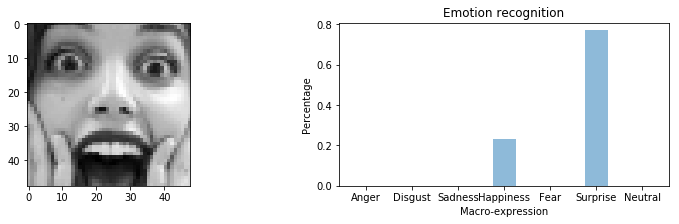

In [182]:
#Predicting aver all the faces detected
if all_faces == []:
    print("Face NOT detected!")
for face in all_faces:
    
    x = kimg.img_to_array(face)
    x = np.expand_dims(x, axis = 0)
    x /= 255

    predicted_label = model.predict(x)
    
    #Plot all the images along its predictions
    f = plt.figure()
    f.set_figheight(3)
    f.set_figwidth(13)
    f.add_subplot(1,2, 1)
    plt.imshow(x.squeeze())
    f.add_subplot(1,2, 2)
    plot_emotion(predicted_label[0])
    plt.show(block=True)

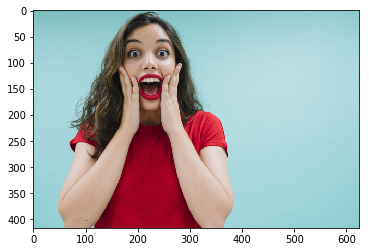

In [183]:
# Show the original image, without aligning or cropping
img = kimg.load_img(image_file)
plt.imshow(img)

## Input stream

In order to use the system in the camera of your computer, first the camera needs to be turned on, then the system will automatically connect with it.
-------------------> To EXIT press "q"

In [199]:
model = load_model('models/stream.h5')
emotions = ('Anger', 'Disgust', 'Sadness', 'Happiness', 'Fear', 'Surprise', 'Neutral')
flags = [i for i in dir(cv2) if i.startswith('COLOR_')]
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
cap = cv2.VideoCapture(0)

while(True):
    ret, img = cap.read()
    if ret is True:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        continue

    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x,y,w,h) in faces:
        #Draw rectangle over the face
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)

        #Crop, Graysacale and resize face
        detected_face = img[int(y):int(y+h), int(x):int(x+w)]
        detected_face = cv2.cvtColor(detected_face, cv2.COLOR_BGR2GRAY)
        detected_face = cv2.resize(detected_face, (48, 48))
      
        #Convert image to format valid for predictions
        img_pixels = kimg.img_to_array(detected_face)
        img_pixels = np.expand_dims(img_pixels, axis = 0)
        img_pixels /= 255 

        #Predict macro-expression
        predictions = model.predict(img_pixels)
        max_index = np.argmax(predictions[0])
        emotion = emotions[max_index]

        #Write emotion text above rectangle
        cv2.putText(img, emotion, (int(x), int(y)), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)


    cv2.imshow('img',img)

    if cv2.waitKey(1) & 0xFF == ord('q'): #press q to quit
        break
#kill open cv things		
cap.release()
cv2.destroyAllWindows()